In [1]:
import argparse
from typing import List, Tuple

import cv2
import numpy as np
import onnxruntime as ort
import torch

from ultralytics.utils import ASSETS, YAML
from ultralytics.utils.checks import check_requirements, check_yaml


class YOLOv8:
    """
    YOLOv8 object detection model class for handling ONNX inference and visualization.

    This class provides functionality to load a YOLOv8 ONNX model, perform inference on images,
    and visualize the detection results with bounding boxes and labels.

    Attributes:
        onnx_model (str): Path to the ONNX model file.
        input_image (str): Path to the input image file.
        confidence_thres (float): Confidence threshold for filtering detections.
        iou_thres (float): IoU threshold for non-maximum suppression.
        classes (List[str]): List of class names from the COCO dataset.
        color_palette (np.ndarray): Random color palette for visualizing different classes.
        input_width (int): Width dimension of the model input.
        input_height (int): Height dimension of the model input.
        img (np.ndarray): The loaded input image.
        img_height (int): Height of the input image.
        img_width (int): Width of the input image.

    Methods:
        letterbox: Resize and reshape images while maintaining aspect ratio by adding padding.
        draw_detections: Draw bounding boxes and labels on the input image based on detected objects.
        preprocess: Preprocess the input image before performing inference.
        postprocess: Perform post-processing on the model's output to extract and visualize detections.
        main: Perform inference using an ONNX model and return the output image with drawn detections.

    Examples:
        Initialize YOLOv8 detector and run inference
        >>> detector = YOLOv8("yolov8n.onnx", "image.jpg", 0.5, 0.5)
        >>> output_image = detector.main()
    """

    def __init__(self, onnx_model: str, input_image: str, confidence_thres: float, iou_thres: float):
        """
        Initialize an instance of the YOLOv8 class.

        Args:
            onnx_model (str): Path to the ONNX model.
            input_image (str): Path to the input image.
            confidence_thres (float): Confidence threshold for filtering detections.
            iou_thres (float): IoU threshold for non-maximum suppression.
        """
        self.onnx_model = onnx_model
        self.input_image = input_image
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres

        # Load the class names from the COCO dataset
        self.classes = YAML.load(check_yaml("coco8.yaml"))["names"]

        # Generate a color palette for the classes
        self.color_palette = np.random.uniform(0, 255, size=(len(self.classes), 3))

    def letterbox(self, img: np.ndarray, new_shape: Tuple[int, int] = (640, 640)) -> Tuple[np.ndarray, Tuple[int, int]]:
        """
        Resize and reshape images while maintaining aspect ratio by adding padding.

        Args:
            img (np.ndarray): Input image to be resized.
            new_shape (Tuple[int, int]): Target shape (height, width) for the image.

        Returns:
            img (np.ndarray): Resized and padded image.
            pad (Tuple[int, int]): Padding values (top, left) applied to the image.
        """
        shape = img.shape[:2]  # current shape [height, width]

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

        # Compute padding
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = (new_shape[1] - new_unpad[0]) / 2, (new_shape[0] - new_unpad[1]) / 2  # wh padding

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))

        return img, (top, left)

    def draw_detections(self, img: np.ndarray, box: List[float], score: float, class_id: int) -> None:
        """Draw bounding boxes and labels on the input image based on the detected objects."""
        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f"{self.classes[class_id]}: {score:.2f}"

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(
            img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
        )

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def preprocess(self) -> Tuple[np.ndarray, Tuple[int, int]]:
        """
        Preprocess the input image before performing inference.

        This method reads the input image, converts its color space, applies letterboxing to maintain aspect ratio,
        normalizes pixel values, and prepares the image data for model input.

        Returns:
            image_data (np.ndarray): Preprocessed image data ready for inference with shape (1, 3, height, width).
            pad (Tuple[int, int]): Padding values (top, left) applied during letterboxing.
        """
        # Read the input image using OpenCV
        self.img = cv2.imread(self.input_image)

        # Get the height and width of the input image
        self.img_height, self.img_width = self.img.shape[:2]

        # Convert the image color space from BGR to RGB
        img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)

        img, pad = self.letterbox(img, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data, pad

    def postprocess(self, input_image: np.ndarray, output: List[np.ndarray], pad: Tuple[int, int]) -> np.ndarray:
        """
        Perform post-processing on the model's output to extract and visualize detections.

        This method processes the raw model output to extract bounding boxes, scores, and class IDs.
        It applies non-maximum suppression to filter overlapping detections and draws the results on the input image.

        Args:
            input_image (np.ndarray): The input image.
            output (List[np.ndarray]): The output arrays from the model.
            pad (Tuple[int, int]): Padding values (top, left) used during letterboxing.

        Returns:
            (np.ndarray): The input image with detections drawn on it.
        """
        # Transpose and squeeze the output to match the expected shape
        outputs = np.transpose(np.squeeze(output[0]))

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []

        # Calculate the scaling factors for the bounding box coordinates
        gain = min(self.input_height / self.img_height, self.input_width / self.img_width)
        outputs[:, 0] -= pad[1]
        outputs[:, 1] -= pad[0]

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][4:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) / gain)
                top = int((y - h / 2) / gain)
                width = int(w / gain)
                height = int(h / gain)

                # Add the class ID, score, and box coordinates to the respective lists
                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        # Iterate over the selected indices after non-maximum suppression
        for i in indices:
            # Get the box, score, and class ID corresponding to the index
            box = boxes[i]
            score = scores[i]
            class_id = class_ids[i]

            # Draw the detection on the input image
            self.draw_detections(input_image, box, score, class_id)

        # Return the modified input image
        return input_image

    def main(self) -> np.ndarray:
        """
        Perform inference using an ONNX model and return the output image with drawn detections.

        Returns:
            (np.ndarray): The output image with drawn detections.
        """
        # Create an inference session using the ONNX model and specify execution providers
        session = ort.InferenceSession(self.onnx_model, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])

        # Get the model inputs
        model_inputs = session.get_inputs()

        # Store the shape of the input for later use
        input_shape = model_inputs[0].shape
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]

        # Preprocess the image data
        img_data, pad = self.preprocess()

        # Run inference using the preprocessed image data
        outputs = session.run(None, {model_inputs[0].name: img_data})

        # Perform post-processing on the outputs to obtain output image
        return self.postprocess(self.img, outputs, pad)

In [2]:
detection = YOLOv8("../src-tauri/resources/models/yolo11n.onnx","../src-tauri/resources/images/bailey.jpeg",0.5, 0.5)

In [3]:
output_image = detection.main()

/Users/Gerry.Wagner/develop/psueng/sweng-894-capstone/.venv/lib/python3.11/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


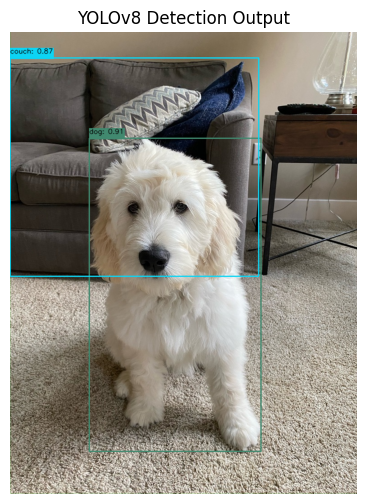

In [4]:
import matplotlib.pyplot as plt

# Convert BGR (OpenCV) to RGB for display
output_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(output_rgb)
plt.axis('off')
plt.title('YOLOv8 Detection Output')
plt.show()